<a href="https://colab.research.google.com/github/JingQian87/AppliedDL/blob/master/A3_jq2282.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assginment 3 Experiment with hyperparameters
### Jing Qian(jq2282)

## Instructions
Design and run several short experiments to compare the effect of different learning rates, activation functions, optimizers, and weight initialization strategies. 

Produce plots using TensorBoard to compare the results. The goal is to gain familiarity with these choices and their impact.

Using MNIST, design and run experiments to compare:
* Three different learning rates.
* Three different activations.
* Three different optimizers.
* Three different weight initialization strategies.

For each experiment,
*  Visualize results with TensorBoard (and include a screenshot with submission).
* Include a brief write up (two paragraphs give or take) summarizing your findings. Are the results what you expected? Why or why not?


In [1]:
!pip install -q tf-nightly-2.0-preview

# Load the TensorBoard notebook extension
%load_ext tensorboard.notebook

    100% |████████████████████████████████| 79.7MB 536kB/s 
    100% |████████████████████████████████| 358kB 21.5MB/s 
    100% |████████████████████████████████| 3.0MB 11.1MB/s 
    100% |████████████████████████████████| 61kB 22.3MB/s 


In [0]:
import tensorflow as tf
import datetime

In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [0]:
# Load data from MNIST
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

## Part 1. Three different learning rates.


In [0]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

## Part 2. Three different activations.
https://keras.io/activations/

## Part 3. Three different optimizers.
https://keras.io/optimizers/

## Part 4. Three different weight initialization strategies.
https://keras.io/initializers/

In [0]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import zipfile

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Step1. Load and explore data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
local_zip = '/content/mini_flowers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
!ls '/tmp/'
!ls '/tmp/train/'

CUlandmarks  drivefs_ipc.0  drivefs_ipc.0_shell  LICENSE.txt  train  val
daisy  dandelion  roses  sunflowers  tulips


In [0]:
base_dir = '/tmp'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'val')

In [0]:
total_train = 0
for i in os.listdir(train_dir):
  tmp = len(os.listdir(os.path.join(train_dir, i)))
  print('Training ', i, ' images:', tmp)
  total_train += tmp
 
total_val = 0
for i in os.listdir(validation_dir):
  tmp = len(os.listdir(os.path.join(validation_dir, i)))
  print('Validation ', i, ' images:', tmp)
  total_val += tmp
  
print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)

Training  sunflowers  images: 200
Training  tulips  images: 200
Training  roses  images: 200
Training  daisy  images: 200
Training  dandelion  images: 200
Validation  sunflowers  images: 100
Validation  tulips  images: 100
Validation  roses  images: 100
Validation  daisy  images: 100
Validation  dandelion  images: 100
--
Total training images: 1000
Total validation images: 500


### Step2. Use VGG model

In [0]:
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
#conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step


In [0]:
# Images be resized to TARGET_SHAPE * TARGET_SHAPE pixels as they're read off the disk
TARGET_SHAPE = 150
BATCH_SIZE = 32

In [0]:
# Cache activations for our training and validation data
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))#from block5 of VGG16
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base.predict(inputs_batch)
        # print(features_batch.shape)
        # (32, 4, 4, 512)
        # Think: batch_size, rows, cols, channels
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
FLATTENED_SHAPE = 4 * 4 * 512

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.summary()

history = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 0s 496us/sample - loss: 1.4928 - acc: 0.4550 - val_loss: 0.9190 - val_acc: 0.6800
Epoch 2/50
1000/1000 [==============================] - 0s 319us/sample - loss: 0.8457 - acc: 0.6940 - val_loss: 0.7644 - val_acc: 0.7440
Epoch 3/50
1000/1000 [==============================] - 0s 296us/sample - loss: 0.6139 - acc: 0.7820 - val_loss: 0.6584 - val_acc: 0.7700
Epoch 4/50
1000/1000 [==============================] - 0s 298us/sample - loss: 0.5141 - acc: 0.8180 - val_loss: 0.6468 - val_acc: 0.7660
Epoch 5/50
1000/1000 [==============================] - 0s 298us/sample - loss: 0.4305 - acc: 0.8500 - val_loss: 0.5997 - val_acc: 0.7800
Epoch 6/50
1000/1000 [==============================] - 0s 321us/sample - loss: 0.3421 - acc: 0.8830 - val_loss: 0.6434 - val_acc: 0.7400
Epoch 7/50
1000/1000 [==============================] - 0s 313us/sample - loss: 0.2716 - acc: 0.9090 - val_loss: 0.6728 - val

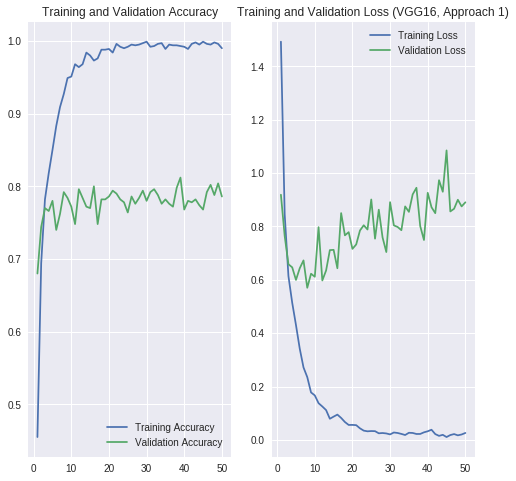

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (VGG16, Approach 1)')
plt.show()

### Step 3. Add fine tuning (Approach 2)

In [0]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 18,912,069
Trainable params: 18,912,069
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv_base.trainable = False
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 50
history2 = model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/50
16/16 [==============================] - 3s 184ms/step - loss: 0.9102 - acc: 0.6520
 - 11s - loss: 1.9253 - acc: 0.4040 - val_loss: 0.9102 - val_acc: 0.6520
Epoch 2/50
16/16 [==============================] - 3s 169ms/step - loss: 0.8086 - acc: 0.7040
 - 10s - loss: 0.9429 - acc: 0.6460 - val_loss: 0.8086 - val_acc: 0.7040
Epoch 3/50
16/16 [==============================] - 3s 168ms/step - loss: 0.7328 - acc: 0.7400
 - 10s - loss: 0.8848 - acc: 0.6570 - val_loss: 0.7328 - val_acc: 0.7400
Epoch 4/50
16/16 [==============================] - 3s 170ms/step - loss: 0.6815 - acc: 0.7360
 - 10s - loss: 0.8050 - acc: 0.7080 - val_loss: 0.6815 - val_acc: 0.7360
Epoch 5/50
16/16 [==============================] - 3s 172ms/step - loss: 0.6337 - acc: 0.7700
 - 10s - loss: 0.7128 - acc: 0.7370 - val_loss: 0.6337 - val_acc: 0.7700
Epoch 6/50
16/16 [==============================] - 3s 169ms/step - loss: 0.5885 - acc: 0.8040
 - 10s - loss: 0.7022 - acc: 0.7300 - val_loss: 0.5885 - val_acc:

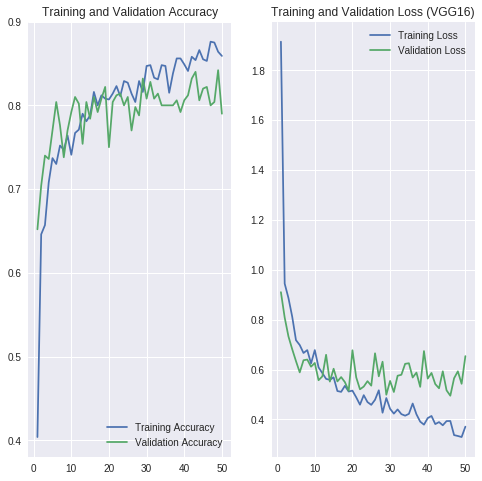

In [0]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (VGG16)')
plt.show()

### Step 4. Report of Part 1.1.
In this problem, I used VGG16 based model to classify the mini-flowers dataset.
I tried both approach 1 (feature extraction) and approach 1 (fine tuning).

From the plot above, we could see:
* Approach 1 becomes overfitting after about 1 epoches. The training accuracy quickly increases to near 100% and validation accuracy is fluctuated a little below 80%.
* Approach 2 becomes overfitting after about 15 epoches. The validation accuracy is a little above 80%.

## 2. Run experiments using at least two pretrained convolutional bases
Run experiments using at least two pretrained convolutional bases and compare your results. Include a short, informal write-up (using bullet points is fine). What differences do you see, and why? Read the associated papers to learn more about the networks you’re using, linked from the API doc.

### Model 1: InceptionV3


In [0]:
from keras.applications.inception_v3 import InceptionV3
conv_base3 = InceptionV3(weights='imagenet',include_top=False, input_shape=(150, 150, 3))
conv_base3.summary()

87916544/87910968 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))#from block5 of VGG16
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base3.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [0]:
FLATTENED_SHAPE = 3 * 3 * 2048

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history5 = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 2s 2ms/sample - loss: 8.6892 - acc: 0.3990 - val_loss: 5.9858 - val_acc: 0.5960
Epoch 2/50
1000/1000 [==============================] - 0s 437us/sample - loss: 7.0262 - acc: 0.5340 - val_loss: 6.3275 - val_acc: 0.5820
Epoch 3/50
1000/1000 [==============================] - 0s 431us/sample - loss: 6.2728 - acc: 0.5790 - val_loss: 6.0903 - val_acc: 0.6020
Epoch 4/50
1000/1000 [==============================] - 0s 445us/sample - loss: 6.0622 - acc: 0.5940 - val_loss: 5.0466 - val_acc: 0.6560
Epoch 5/50
1000/1000 [==============================] - 0s 429us/sample - loss: 5.7165 - acc: 0.6180 - val_loss: 5.4613 - val_acc: 0.6140
Epoch 6/50
1000/1000 [==============================] - 0s 433us/sample - loss: 4.7544 - acc: 0.6540 - val_loss: 4.2960 - val_acc: 0.6940
Epoch 7/50
1000/1000 [==============================] - 0s 437us/sample - loss: 4.1314 - acc: 0.7020 - val_loss: 3.9082 - val_a

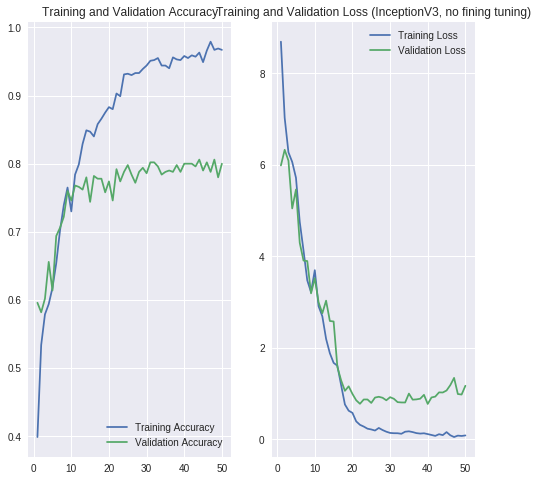

In [0]:
acc = history5.history['acc']
val_acc = history5.history['val_acc']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (InceptionV3, no fining tuning)')
plt.show()

### Model 2: MobileNetV2

In [0]:
from keras.applications.mobilenet_v2 import MobileNetV2
conv_base4 = MobileNetV2(weights='imagenet',include_top=False, input_shape=(128,128, 3))
#conv_base4.summary()
datagen = ImageDataGenerator(rescale=1./255)

TARGET_SHAPE = 128
BATCH_SIZE = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 1280))#from ResNet
    labels = np.zeros(shape=(sample_count, 5))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
      
        features_batch = conv_base4.predict(inputs_batch)
        
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)


FLATTENED_SHAPE = 4 * 4 * 1280

train_features = np.reshape(train_features, (total_train, FLATTENED_SHAPE))
validation_features = np.reshape(validation_features, (total_val, FLATTENED_SHAPE))
EPOCHS = 50
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=FLATTENED_SHAPE))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history4 = model.fit(train_features, train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(validation_features, validation_labels))

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 1s 1ms/sample - loss: 5.7311 - acc: 0.5290 - val_loss: 4.8509 - val_acc: 0.6240
Epoch 2/50
1000/1000 [==============================] - 0s 474us/sample - loss: 4.4046 - acc: 0.6740 - val_loss: 4.4189 - val_acc: 0.6680
Epoch 3/50
1000/1000 [==============================] - 0s 489us/sample - loss: 2.9309 - acc: 0.7530 - val_loss: 1.6378 - val_acc: 0.7860
Epoch 4/50
1000/1000 [==============================] - 0s 487us/sample - loss: 0.9070 - acc: 0.8690 - val_loss: 0.7887 - val_acc: 0.8460
Epoch 5/50
1000/1000 [==============================] - 0s 473us/sample - loss: 0.4480 - acc: 0.8960 - val_loss: 0.6113 - val_acc: 0.8500
Epoch 6/50
1000/1000 [==============================] - 0s 485us/sample - loss: 0.2073 - acc: 0.9440 - val_loss: 0.7987 - val_acc: 0.7980
Epoch 7/50
1000/1000 [======================

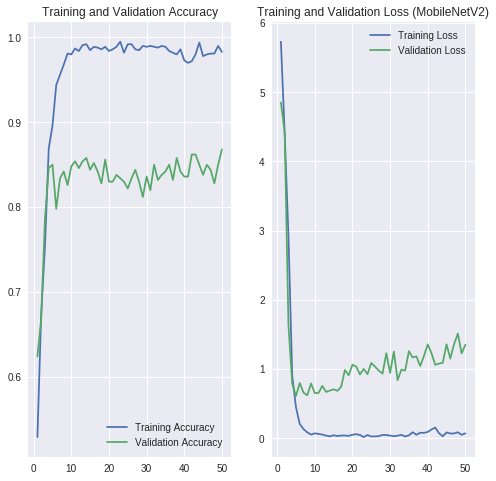

In [0]:
acc = history4.history['acc']
val_acc = history4.history['val_acc']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (MobileNetV2)')
plt.show()

### Report of Part 1.2.
In this problem, I tried two pretrained models as the convolutionary base: InceptionV3 and MobileNetV2.
I chose the same parameters for these models as the ones for VGG16 in Problem 1.1 except for one parameter, the TARGET_SHAPE of MobileNetV2 is set to 128 due to its fixed options of input shape while others is 150.
Approach 1 is used for better comparison on the pretrained models themselves.

From the accuracy plot of training and validation datasets from four models, one could have following observations:
* VGG16 becomes overfitting after about 1 epoches. The training accuracy quickly increases near to 100% and validation accuracy is fluctuated a little below 80%
* InceptionV3 becomes overfitting after about 10 epoches. The validation accuracy is a little below 80%.
* MobileNetV2 becomes overfitting after about 5 epoches. The validation accuracy is fluctuating around 85%.

From the document, we know:
* VGG16 has 138357544 parameters and depth = 23.
* InceptionV3 has 23851784 parameters, which is one magnitude smallerthan that of VGG16. InceptionV3 has depth=159.
* MobileNetV2 has the fewest parameters among the pretrained models listed, which is 3538984. MobileNetV2 has depth 88.

We may have following conclusions from the obeservations and documents:
* VGG16 has the largest number of parameters, which leads to its fastest overfitting.
* The factorizing convolution technology helps InceptionV3 to get similar network efficiency as VGG16 in this task with many fewer parameters than VGG16.
* The bottleneck depth-separable convolution with residuals architecture of MobileNetV2 enables faster training and better accuracy with many fewer parameters than the other two pretrained models.
* All three models produce overfitting results, which means that we could do such classification with much smaller model.